In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import KFold

In [5]:
from tqdm.auto import tqdm

In [6]:
datos = pd.read_csv('../data/bank-full.csv', sep=';')
datos.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
variables = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]


In [8]:
df = datos[variables]

In [9]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [14]:
categorical = [col for col in df.select_dtypes(include=['object']).columns if col != 'y']
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [15]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* balance
* day
* duration
* previous

In [16]:
def calculate_auc(feature, target):
    auc = roc_auc_score(target, feature)
    if auc < 0.5:
        auc = roc_auc_score(target, -feature)
    return auc

In [17]:
auc_scores = {}

for col in numerical:
    auc = calculate_auc(df_train[col], df_train['y'])
    auc_scores[col] = auc

In [18]:
auc_scores

{'age': 0.512185717527344,
 'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'campaign': 0.5714543015682159,
 'pdays': 0.5901276247352144,
 'previous': 0.5985653242764153}

In [19]:
variables_of_interest = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
highest_auc = max(variables_of_interest, key=lambda x: auc_scores[x])
print(f"La variable con el AUC más alto es: {highest_auc}")
print("AUC Scores:")
for var in variables_of_interest:
    print(f"{var}: {auc_scores[var]:.4f}")

La variable con el AUC más alto es: duration
AUC Scores:
age: 0.5122
balance: 0.5888
day: 0.5260
duration: 0.8147
campaign: 0.5715
pdays: 0.5901
previous: 0.5986


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69
* 0.79
* 0.89
* 0.99

In [20]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

'''del df_train['y']
del df_val['y']
del df_test['y']'''

"del df_train['y']\ndel df_val['y']\ndel df_test['y']"

In [21]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)
    
    return dv, model

In [22]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
dv, model = train(df_train, y_train, C=1.0)

In [24]:
y_pred = predict(df_val, dv, model)

In [25]:
auc = roc_auc_score(y_val, y_pred)
print(f"ACU: {auc}")

ACU: 0.9004143531129565


In [26]:
# Función para convertir DataFrame a lista de diccionarios
def df_to_dict(df):
    return df[categorical + numerical].to_dict(orient='records')

# Preparar los datos
train_dicts = df_to_dict(df_train)
val_dicts = df_to_dict(df_val)

# Inicializar y ajustar DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Preparar las etiquetas
y_train = df_train['y'].values
y_val = df_val['y'].values

# Inicializar y entrenar el modelo de Regresión Logística
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
y_pred = model.predict_proba(X_val)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_val, y_pred)

print(f"AUC en el conjunto de validación: {auc:.3f}")

AUC en el conjunto de validación: 0.900


# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

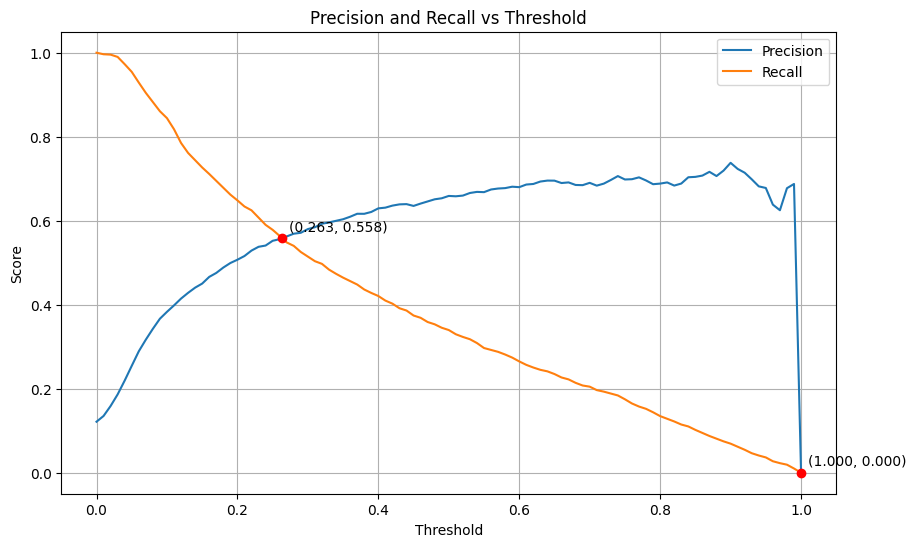

Las curvas de precisión y recuperación se intersectan en los siguientes umbrales:
Intersección 1: umbral = 0.263, valor = 0.558
Intersección 2: umbral = 1.000, valor = 0.000


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Definir los umbrales
thresholds = np.linspace(0.0, 1.0, num=101)

# Listas para almacenar precisión y recuperación para cada umbral
precisions = []
recalls = []

# Calcular precisión y recuperación para cada umbral
for threshold in thresholds:
    y_pred_binary = (y_pred >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred_binary))
    recalls.append(recall_score(y_val, y_pred_binary))

# Convertir a arrays de numpy para operaciones más eficientes
precisions = np.array(precisions)
recalls = np.array(recalls)

# Encontrar los puntos de intersección
diff = precisions - recalls
sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Graficar precisión y recuperación
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)

# Marcar y anotar los puntos de intersección
intersections = []
for idx in sign_changes:
    # Interpolación lineal para encontrar el punto exacto de intersección
    x1, x2 = thresholds[idx], thresholds[idx + 1]
    y1, y2 = diff[idx], diff[idx + 1]
    intersection_x = x1 + (0 - y1) * (x2 - x1) / (y2 - y1)
    intersection_y = np.interp(intersection_x, thresholds, precisions)
    
    intersections.append((intersection_x, intersection_y))
    
    plt.plot(intersection_x, intersection_y, 'ro')
    plt.annotate(f'({intersection_x:.3f}, {intersection_y:.3f})', 
                 (intersection_x, intersection_y),
                 xytext=(5, 5), textcoords='offset points')

plt.show()

print("Las curvas de precisión y recuperación se intersectan en los siguientes umbrales:")
for i, (x, y) in enumerate(intersections, 1):
    print(f"Intersección {i}: umbral = {x:.3f}, valor = {y:.3f}")

In [37]:
y_val = (y_val == 'yes').astype(int)
y_val

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [87]:
thresholds = np.linspace(0.0, 1.0, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [112]:
round = 4
scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    
    fn = (predict_negative & actual_positive).sum()
    
    precision = (tp / (tp +fp)).round(round)
    
    recall = (tp / (tp + fn)).round(round)
    
    scores.append((t, precision, recall))
    



In [113]:
scores

[(0.0, 0.1214, 1.0),
 (0.01, 0.1351, 0.9964),
 (0.02, 0.1588, 0.9954),
 (0.03, 0.1865, 0.99),
 (0.04, 0.2194, 0.9727),
 (0.05, 0.2544, 0.9545),
 (0.06, 0.289, 0.929),
 (0.07, 0.3168, 0.9044),
 (0.08, 0.3426, 0.8825),
 (0.09, 0.3667, 0.8607),
 (0.1, 0.3831, 0.8443),
 (0.11, 0.3984, 0.8179),
 (0.12, 0.4146, 0.7851),
 (0.13, 0.4283, 0.7614),
 (0.14, 0.4407, 0.7441),
 (0.15, 0.4503, 0.7268),
 (0.16, 0.4663, 0.7113),
 (0.17, 0.4757, 0.6949),
 (0.18, 0.4885, 0.6785),
 (0.19, 0.4993, 0.6621),
 (0.2, 0.5071, 0.6485),
 (0.21, 0.5159, 0.6339),
 (0.22, 0.5289, 0.6248),
 (0.23, 0.5379, 0.6075),
 (0.24, 0.5409, 0.5902),
 (0.25, 0.5522, 0.5783),
 (0.26, 0.5562, 0.5638),
 (0.27, 0.5626, 0.5483),
 (0.28, 0.5691, 0.5401),
 (0.29, 0.5713, 0.5255),
 (0.3, 0.5801, 0.5146),
 (0.31, 0.5846, 0.5036),
 (0.32, 0.5928, 0.4973),
 (0.33, 0.596, 0.4836),
 (0.34, 0.5998, 0.4736),
 (0.35000000000000003, 0.6036, 0.4645),
 (0.36, 0.6095, 0.4563),
 (0.37, 0.6165, 0.4481),
 (0.38, 0.6165, 0.4362),
 (0.39, 0.6209, 0.4281

In [114]:
columns = ['t', 'Precision', 'Recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,t,Precision,Recall
0,0.00,0.1214,1.0000
1,0.01,0.1351,0.9964
2,0.02,0.1588,0.9954
3,0.03,0.1865,0.9900
4,0.04,0.2194,0.9727
...,...,...,...
96,0.96,0.6383,0.0273
97,0.97,0.6250,0.0228
98,0.98,0.6774,0.0191
99,0.99,0.6875,0.0100


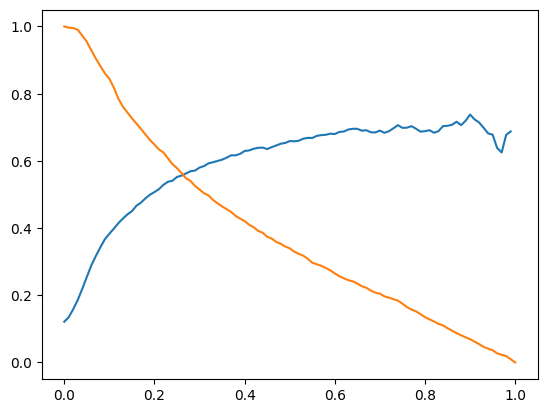

In [115]:
plt.plot(df_scores.t, df_scores.Precision)
plt.plot(df_scores.t, df_scores.Recall)

In [111]:
df_scores

,t,Precision,Recall
0,0.00,0.121,1.000
1,0.01,0.135,0.996
2,0.02,0.159,0.995
3,0.03,0.186,0.990
4,0.04,0.219,0.973
...,...,...,...
96,0.96,0.638,0.027
97,0.97,0.625,0.023
98,0.98,0.677,0.019
99,0.99,0.688,0.010


In [119]:
# Calcular la diferencia entre a y b
diff = df_scores['Precision'] - df_scores['Recall']

# Encontrar los índices donde el signo cambia (es decir, el punto de intersección)
sign_change = np.where(np.diff(np.sign(diff)))[0]

# Si hay intersección, se puede encontrar el valor de t donde ocurre
if len(sign_change) > 0:
    # Interpolación lineal para obtener un valor más preciso de t
    idx = sign_change[0]
    t1, t2 = df_scores['t'].iloc[idx], df_scores['t'].iloc[idx + 1]
    a1, a2 = df_scores['Precision'].iloc[idx], df_scores['Precision'].iloc[idx + 1]
    b1, b2 = df_scores['Recall'].iloc[idx], df_scores['Recall'].iloc[idx + 1]

    # Calcular el valor exacto de t usando interpolación lineal
    t_intercept = (t1 + (t2 - t1) * (b1 - a1) / ((a2 - a1) - (b2 - b1))).round(3)

    print(f"Las líneas se interceptan en t = {t_intercept}")
else:
    print("No se encontró ninguna intersección.")

Las líneas se interceptan en t = 0.263


In [120]:
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])